### Read in the face image data

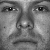

In [1]:
from PIL import Image
import numpy as np

def process_img_and_labels(fpath):
    dct = {
        'path': [],
        'label': [],
        'image': []
    }

    with open(fpath) as train_f:
        for line in train_f:
            path, label = line.strip().split()
            dct['path'].append(path)
            dct['label'].append(label)

            im = Image.open(path)
            im_matrix = np.asarray(im, dtype=np.uint8)
            im_matrix.resize(2500)
            dct['image'].append(im_matrix)

    return dct

train = process_img_and_labels('./faces/train.txt')
test = process_img_and_labels('./faces/test.txt')

X = np.zeros(shape=(540, 2500)) 
X_test = np.zeros(shape=(100, 2500)) 

for i in range(len(train['image'])):
    X[i:] = train['image'][i]

for i in range(len(test['image'])):
    X_test[i:] = test['image'][i]

Image.open(train['path'][4])

### Compute the average face

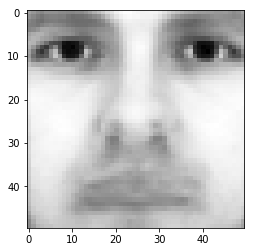

In [2]:
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

mu = X.sum(axis=0)/len(X)

def show_face(vector, ax=None):
    if ax:
        ax.imshow(vector.reshape(50,50), cmap=cm.Greys_r)
    else:
        plt.imshow(vector.reshape(50,50), cmap=cm.Greys_r)

show_face(mu)

### Mean Subtraction

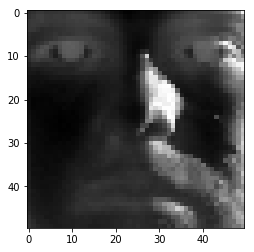

In [3]:
X = X - mu
X_test = X_test - mu
show_face(X[5])

### Eigenface

Perform Singular Value Decomposition (SVD) on training set X (X = UΣV T ) to get
matrix V T , where each row of V T has the same dimension as the face image. We refer to v i ,
the i -th row of V T , as i -th eigenface. Display the first 10 eigenfaces as 10 images in grayscale.

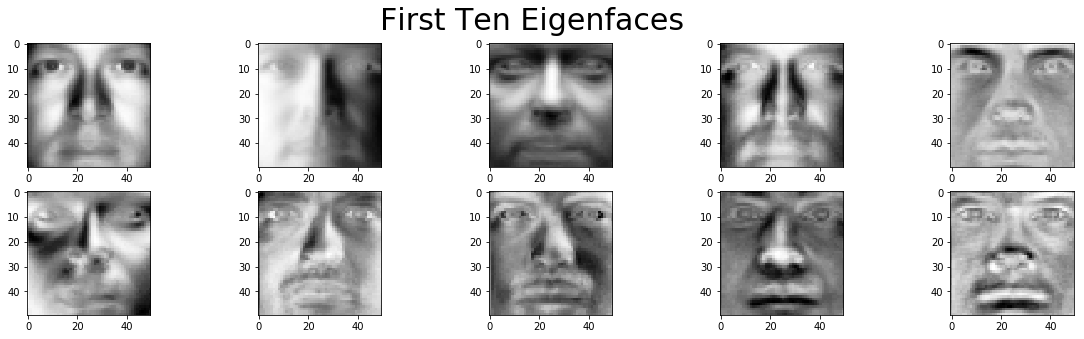

In [4]:
from numpy.linalg import svd
U, sigma, V_t = svd(X)

fig, ax = plt.subplots(2,5)
fig.set_size_inches((20,5))

for i in range(5):
    show_face(V_t[i], ax=ax[0,i])
    show_face(V_t[i+5], ax=ax[1,i])

title = fig.suptitle('First Ten Eigenfaces', fontsize=30)

### Rank R order approximation


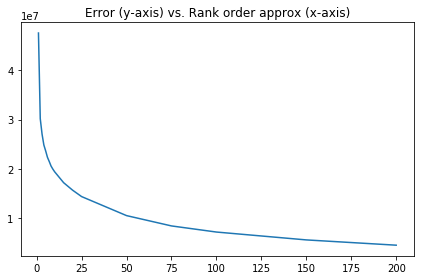

In [5]:
def get_approx(matrix, r=1):
    U, s, V = svd(matrix)
    return np.dot(U[:,:r], np.dot(np.diag(s[:r]), V[:r,:]))

sample_at = [1,2,3,4,5,6,7,8,9,10,15,20,25,50,75,100,150,200]
err = [abs(get_approx(X, r=R) - X).sum() for R in sample_at]

plt.title("Error (y-axis) vs. Rank order approx (x-axis)")
plt.plot(sample_at, err)
plt.tight_layout()

As you can see, almost all of the error goes away after using a rank 25 order approximation. There is a lot of duplicative data in our dataset of faces

In [6]:
from sklearn.linear_model import LogisticRegression
labels = train['label']
r = 10

_, _, V = svd(X)
F = np.dot(X, V[:r].transpose())
F_test = np.dot(X_test, V[:r].transpose())
    
lg = LogisticRegression(multi_class='ovr')
lg.fit(F, labels)
predictions = lg.predict(F_test)
print("The accuracy at r = 10")
print((predictions == np.array(test['label'])).sum()/len(predictions))



The accuracy at r = 10
0.79


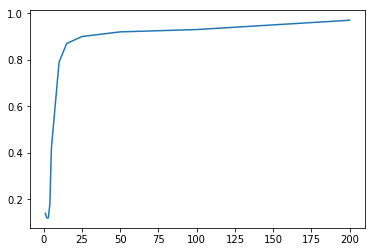

In [7]:
from sklearn.linear_model import LogisticRegression
labels = train['label']
classes = set(labels)
models = dict()

sample = [1,2,3,4,5,10,15,25,50,100,200]
accuracy = list()

for r in sample:
    _, _, V = svd(X)
    F = np.dot(X, V[:r].transpose())
    F_test = np.dot(X_test, V[:r].transpose())
    
    lg = LogisticRegression(multi_class='ovr')
    lg.fit(F, labels)
    predictions = lg.predict(F_test)
    accuracy.append((predictions == np.array(test['label'])).sum()/len(predictions))

plt.plot(sample,accuracy)

In [8]:
M = np.array([[1,0,3],[3,7,2],[2,-2,8],[0,-1,1],[5,8,7]])
A = np.dot(M.transpose(),M)
B = np.dot(M,M.transpose())


In [27]:
np.dot(M, np.array([3,-1,-1]))
np.set_printoptions(precision=2, suppress=True)

In [41]:
np.linalg.eig(A)

(array([ 214.67,   -0.  ,   69.33]), array([[ 0.43,  0.9 , -0.01],
        [ 0.62, -0.3 , -0.73],
        [ 0.66, -0.3 ,  0.68]]))

In [42]:
np.linalg.eig(B)

(array([ 214.67,   -0.  ,   69.33,    0.  ,   -0.  ]),
 array([[-0.16, -0.96,  0.24, -0.06, -0.11],
        [-0.47, -0.03, -0.45,  0.75, -0.05],
        [-0.34,  0.27,  0.83,  0.33, -0.17],
        [-0.  ,  0.04,  0.17,  0.05,  0.97],
        [-0.8 ,  0.1 , -0.13, -0.57,  0.12]]))

In [43]:
svd(M)

(array([[-0.16, -0.24,  0.95,  0.03, -0.12],
        [-0.47,  0.45, -0.07,  0.1 , -0.75],
        [-0.34, -0.83, -0.31, -0.16, -0.28],
        [-0.  , -0.17, -0.07,  0.98,  0.04],
        [-0.8 ,  0.13, -0.03, -0.  ,  0.59]]),
 array([ 14.65,   8.33,   0.  ]),
 array([[-0.43, -0.62, -0.66],
        [ 0.01,  0.73, -0.68],
        [-0.9 ,  0.3 ,  0.3 ]]))